In [1]:
import logging

import torch
from torch import optim
from torch.utils.data import DataLoader
from data.data_preparer import DataPreparer
from src.predictor.multilayer_perceptron import MultiLayerPerceptronPredictor
from src.predictor.neural_network_trainer import NeuralNetworkTrainer
from src.data.data_reader import DataReader
import os
import pandas as pd
from tools.RestaurantReviewsDataset import RestaurantReviewsDataset
from tools.config_parser import ConfigParser
from tools.profiles_manager import ProfilesManager
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)

while str(os.getcwd())[-3:] != 'src':  # Execute from src-directory root
    os.chdir('..')

In [2]:
businesses, reviews, tips = DataReader().read_data()
user_profiles_list = ProfilesManager().get_user_profiles_names()


def get_trained_models_for_user_profiles(train_test_data_f: tuple, user_profiles_name_f: str):
    trained_models_f = []
    for model_location in os.scandir(ConfigParser().get_value('predictor_model', 'model_dir')):
        trained_model = MultiLayerPerceptronPredictor(input_size=train_test_data_f[0].columns.size, output_size=1)
        trained_optimizer = optim.Adam(trained_model.parameters(), lr=0.002)
        try:
            trained_model.load(trained_optimizer, model_location.path)
            if trained_model.user_profiles_location == user_profiles_name_f:
                trained_models_f.append((trained_model, trained_optimizer))
        except RuntimeError:
            pass
    return trained_models_f


In [7]:
for user_profiles_name in user_profiles_list:
    user_profiles = ProfilesManager().get_user_profiles(user_profiles_name)
    train_test_data = DataPreparer.get_train_test_validate(businesses, reviews, tips, user_profiles)

    trained_models = get_trained_models_for_user_profiles(train_test_data, user_profiles_name)
    nn_trainer = NeuralNetworkTrainer(user_profiles_name, *train_test_data)
    for model, optimizer in trained_models:
        logging.info(f"Testing model with User Profiles: {model.user_profiles_location}")
        model.eval()  # Prepare layers of model for evaluation
        with torch.no_grad():
            testX, testY = train_test_data[1], train_test_data[3]

            testX = testX.head(500)
            testY = testY.head(500)

            dl = RestaurantReviewsDataset(testX.to_numpy(), testY.to_numpy())
            test_loader = DataLoader(dl, batch_size=500)
            for x, y in test_loader:
                # Prepare data
                x, y = DataPreparer.get_tensor_for_ml(x, y)
                # Compute predictions and loss

                predictions = model(x)
                predictions = predictions.cpu().detach().numpy().squeeze().transpose()
                y = y.cpu().detach().numpy().squeeze().transpose()
                result = pd.DataFrame(data=[predictions, y]).transpose()
                result.columns = ['predicted', 'actual']
                result['predicted'] = result['predicted'].transform(lambda x: round(x * 4 + 1))
                result['actual'] = result['actual'].transform(lambda x: int(x * 4 + 1))
                result['difference'] =abs(result['predicted'] - result['actual'])
                print(sum(result['difference']))


INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_15h00__APPROX_USER_PROFILES_top_5.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_17h28__BASIC_USER_PROFILES_50_no_sentiment.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_18h37__BASIC_USER_PROFILES_50_with_sentiment.pt.
INFO:root:Testing model with User Profiles: APPROX_USER_PROFILES_top_5.parquet


391


INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_16h20__BASIC_USER_PROFILES_400_no_sentiment.pt.
INFO:root:Testing model with User Profiles: BASIC_USER_PROFILES_400_no_sentiment.parquet


367


INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_15h00__APPROX_USER_PROFILES_top_5.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_17h28__BASIC_USER_PROFILES_50_no_sentiment.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_18h37__BASIC_USER_PROFILES_50_with_sentiment.pt.
INFO:root:Testing model with User Profiles: BASIC_USER_PROFILES_50_no_sentiment.parquet


343


INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_15h00__APPROX_USER_PROFILES_top_5.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_17h28__BASIC_USER_PROFILES_50_no_sentiment.pt.
INFO:root:Model loaded from predictor/Models/mlp\mlp_2023-04-08_18h37__BASIC_USER_PROFILES_50_with_sentiment.pt.
INFO:root:Testing model with User Profiles: BASIC_USER_PROFILES_50_with_sentiment.parquet


355



Histogram of differences between prediction and actual:


(array([211., 232.,  49.,   7.,   1.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

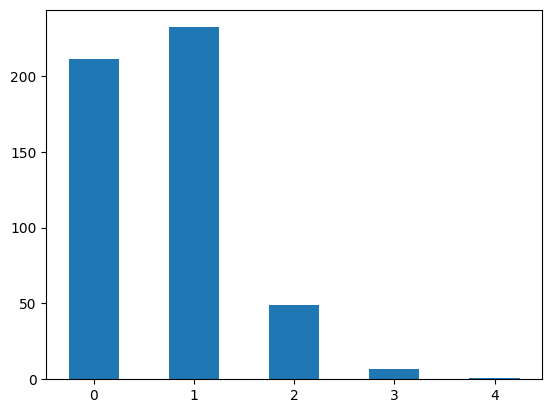

In [8]:
print()
print("Histogram of differences between prediction and actual:")
plt.hist(result['difference'], bins=[0, 1, 2, 3, 4, 5], align='left', rwidth=0.5)